# **ĐỒ ÁN SỐ 01**
- Họ và tên: Nguyễn Trọng Văn
- MSSV: 1712202

_Việc thu thập dữ liệu để khám phá các cộng đồng nghệ sĩ, ban nhạc, bài hát,...  
_Việc thu thập dữ liệu mong muốn có thể trả lời cho một số câu hỏi cụ thể:
* Top playlist có số lượt thích và repost nhiều nhất có phải thuộc về người dùng có nhiều lượt follower nhất?
* Đâu là thể loại nhạc được ưa thích nhất trong 1 năm gần nhất?
* Những người dùng (nghệ sĩ) nào có nhiều bài hát đạt top20 nhất?  

_Dữ liệu thu thập phải tối thiểu từ 1000 mẫu mỗi file thông tin.  
_Dữ liệu thu thập mong muôn sau khi xử lý sẽ giữa lại được ít nhất $\frac{2}{3}$ số lượng để có thể phục vụ cho việc khám phá và trả lời tốt các câu hỏi.  
_Các thông tin quan trọng sẽ được giữ lại nhiều và mong muốn ít bị thiếu giá trị hay nhiễu để việc khám phá được tốt (lượt follower, tên user cho file user, lượt thích, repost cho file playlist, playback repost và like cho file track, các giá trị quan trọng như ID và name sẽ tối thiểu việc mất mát thông tin.)

***Tóm tắt các bước thực hiện phân tích:***
- Các bước thực hiện:  
1. Tiền xử lý dữ liệu:
|Bước|Công việc|
|:----------:|:----------|
|1|Xóa dữ liệu trùng lắp|
|2|Xử lý missing value|
|3|Xử lý nhiễu|
|4|Loại bỏ thuộc tính không mang nhiều thông tin|

Với việc xử lý mising value: 
* Nếu dữ liệu không quan trọng để khai thác hoặc thiếu quá nhiều -> xóa bỏ.
* Nếu dữ liệu cần cho việc phân tích, thiếu ít -> điền rỗng bằng các phương pháp.
Với việc xử lý nhiễu:
* Chuẩn hóa các giá trị chưa chuẩn.
* Quan sát loại bỏ nhiễu, thay thế các giá trị nhiễu.


2. Phân tích dữ liệu: Dùng các công cụ trực quan, sắp xếp, thống kê để tìm ra câu trả lời cho câu hỏi.

## Phần 1: Thu thập dữ liệu

_Khai báo một số thư viện cần thiết.  
_Để phục vụ cho việc thu thập dữ liệu đưuọc tốt, lấy được nhiều thông tin nhất có thể, bài làm sẽ sử dụng cả 2 thư viện parse HTML được Python hỗ trợ để tìm được nhiều trường dữ liệu bao gồm: request_HTML và Beautifulsoup4.  
_Cả 2 thư viện đều có cách sử dụng tương tự như nhau.

In [1]:
import requests
import json
from requests_html import HTMLSession, HTML

import pandas as pd
import numpy as np
import time

from selenium import webdriver
from selenium.webdriver.common.keys import Keys

In [2]:
from bs4 import BeautifulSoup
import urllib.request
import matplotlib.pyplot as plt

### 1.1: Thu thập dữ liệu bằng parse HTML

#### 1.1.1 Thu thập track:

- Với mỗi track có được, ta sẽ thu thập thông qua truyền vào url của track.
- Mỗi track ta sẽ thu được 12 trường tương ứng như mô tả, bao gồm: *trackID, title, url, artist, last_modified, description, genre, play_back, downloads, like, repost, comment*

In [3]:
def replaceNone(value):
    if value is None:
        return ""
    else:
        return value.get('content')

In [4]:
def collectTrack(track_url):
    browser = webdriver.Chrome(executable_path='chromedriver')
    browser.get(track_url)
    time.sleep(1)
    
    page = HTML(html=browser.page_source)
    soup = BeautifulSoup(browser.page_source, 'html')
    
    #track ID
    id_track=soup.find('meta',property="twitter:app:url:googleplay")
    if id_track is None:
        id_track=""
    else:
        id_track=id_track.get('content').split(':')[-1]
    
    #title
    title=soup.find('meta',property='og:title')
    if title is None:
        title=""
    else:
        title=title.get('content')

    #Artist
    artist=soup.find_all('a',class_='soundTitle__username')
    if len(artist)<1:
        artist=""
    else:
        artist=artist[0].text.strip()

    #track's url
    #url=soup.find('meta',property='og:url').get('content')

    #description
    description=soup.find('meta',property='og:description')
    if description is None:
        description=""
    else:
        description=description.get('content')
    
    #Genre
    #genre=soup.find('meta',itemprop="genre")
    
    genre=soup.find('span',class_="sc-truncate sc-type-medium")
    if genre is None:
        genre=""
    else: genre=genre.text
    
    #playback
    play_back=soup.find("meta",property="soundcloud:play_count")
    play_back=replaceNone(play_back)
    
    #downloads:
    downloads=soup.find("meta",property="soundcloud:download_count")
    downloads=replaceNone(downloads)
    
    #like:
    like=soup.find("meta",property="soundcloud:like_count")
    like=replaceNone(like)
    
    #comment
    comment=soup.find('meta',property='soundcloud:comments_count')
    comment=replaceNone(comment)
    
    #repost
    repost=soup.find_all('span',{'aria-hidden':"true"})
    if len(repost)<4:
        repost=""
    else:
        repost=repost[3].text

    #last modified
    last_modified=soup.find_all('time')
    if len(last_modified)<1:
        last_modified=""
    else:
        last_modified=last_modified[0].get('datetime')
    
    browser.close()
    browser.quit()
    return id_track,title,track_url,artist,last_modified,description,genre,play_back,downloads,like,repost,comment

#### 1.1.2: Thu thập user

- Tương tự như thu thập track.
- Với mỗi user ta thu được 11 trường thuộc tính: *user_id, name, url, description, locality, country, sound_count, follower_count, following_count, like, last_modified*

In [5]:
def collectUser(user_url):
    browser = webdriver.Chrome(executable_path='chromedriver')
    browser.get(user_url)
    time.sleep(1)
    
    page = urllib.request.urlopen(user_url)
    soup1 = BeautifulSoup(page, 'html.parser')
    soup=BeautifulSoup(browser.page_source, 'html.parser')
    
    #user ID
    user_id=soup.find('meta',property="twitter:app:url:googleplay").get('content').split(':')[-1]
    
    #user name
    name=soup.find('meta',property='og:title').get('content')
    
    #user's url
    url=soup.find('meta',property='og:url').get('content')
    
    #description
    description=soup.find('meta',property='og:description').get('content')

    #locality
    locality=soup.find('meta',property='og:locality').get('content')

    #country
    country=soup.find('meta',property='og:country-name').get('content')

    #num of sound
    sound_count=soup.find('meta',property='soundcloud:sound_count').get('content')

    #follower
    follower_count=soup.find('meta',property='soundcloud:follower_count').get('content')
    
    #following
    following=soup.find_all('div',class_="infoStats__value sc-font-light")
    if len(following)<2:
        following=""
    else:
        following=following[1].text
    
    #like
    like=soup.find_all('span',{'class':'sidebarHeader__actualTitle'})[1].text.split(' ')[0]
    #last modified:
    last_modified=soup1.find_all('time')
    if last_modified is None or len(last_modified)<1:
        last_modified=""
    else:
        last_modified=last_modified[0].text
        
    browser.close()
    browser.quit()
    return user_id,name,url,description,locality,country,sound_count,follower_count, following,like,last_modified

#### 1.1.3: Thu thập playlist

- Thu thập playlist ta cũng có được 12 thuộc tính: *playlist_id, title, url, num_tracks, description, user, user_url, like, repost, last_modified, tracks_id, tracks_url*
- Trong đó: tracks_id và tracks_url bao gồm các chuỗi chứa các ID và url của các track thuộc một playlist. (Do số lượng track lớn hơn rất nhiều so với số lượng playlist và user nên dữ liệu thu thập sẽ là tổng số tracks, tracks id và url sẽ thu thập đại diện các track đâù tiên tìm thấy)

In [6]:
def collectPlaylist(playlist_url):
    browser = webdriver.Chrome(executable_path='chromedriver')
    browser.get(playlist_url)
    time.sleep(1)
    soup = BeautifulSoup(browser.page_source, 'html.parser')
    
    page = urllib.request.urlopen(playlist_url)
    soup1 = BeautifulSoup(page, 'html.parser')
    head="https://soundcloud.com"
    
    #ID
    playlist_id=soup.find('meta',property="twitter:app:url:googleplay")
    if playlist_id is None:
        playlist_id=""
    else: 
        playlist_id=playlist_id.get('content').split(':')[-1]
    
    #title
    title=soup.find('meta',property="og:title").get('content')
    
    #url
    url=soup.find('meta',property="twitter:url").get('content')
    
    #number of tracks
    num_tracks=soup1.find('meta',itemprop="numTracks")
    if num_tracks is None:
        num_tracks=""
    else:
        num_tracks=num_tracks.get('content')
    
    #description
    description=soup1.find('meta',itemprop="description").get('content')
    
    #user name:
    user=soup1.find('meta',itemprop="name").get('content')
    
    #user url
    user_url=soup.find('meta',property="soundcloud:user").get('content')
    
    #like & repost
    dt=soup.find_all('span',{'aria-hidden':'true'})
    if len(dt)<3:
        like=""
        repost=""
    else:
        like=dt[1].text
        repost=dt[2].text
    
    #last modified
    last_modified=soup.find_all('time')[0].get('datetime')
    
    #infor of every track in playlist:
    tracks_link=soup1.find_all('article',itemprop="track")
    tracks_id=[]
    tracks_url=[]
    
    for track in tracks_link:
        track_url=head+track.find('a').get('href')
        track_infor=collectTrack(track_url)
        tracks_id.append(track_infor[0])
        tracks_url.append(track_url)
        time.sleep(1)
    
    browser.close()
    browser.quit()
    return playlist_id,title,url,num_tracks,description,user,user_url,like,repost,last_modified,tracks_id,tracks_url

#### Thu thập tổng hợp và xuất ra file CSV

Thực hiện thu thập nhiều record bằng phương pháp:
- Thu thập các playlist trước, các playlist được thu thập dựa trên các từ khóa key word thuộc nhiều đối tượng khác nhau (ca sĩ, thể loại, top hạng, chủ đề,...) để mang tính đa dạng và dữ liệu không bị lệch đi nhiều vào cùng 1 lớp.
- Mỗi playlist thu được sẽ có cả thuộc tính về url của user và tập url của các track thuộc playlist đó.
- Để các thuộc tính được liên kết với nhau, ta sẽ thược hiện thu thập thông tin user và track dựa trên playlist có được.

In [7]:
search_playlist='https://soundcloud.com/search/sets?q='
browser = webdriver.Chrome(executable_path='chromedriver')

page = urllib.request.urlopen(search_playlist)
soup1 = BeautifulSoup(page, 'html.parser')

Do điều kiện về đường truyền mạng có thể ảnh hưởng đến việc thu thập dữ liệu, do đó, mỗi lần thu thập dữ liệu playlist được chia thành những phần nhỏ với các từ khóa khác nhau. Dữ liệu được thu thập sẽ được lưu trong file .csv tạm, cuối cùng thực hiện gộp các file tạm đó lại thành file kết quả cuối cùng.

In [8]:
playlist1=['top nhac ngoai','pop','top50','workout','rap','love','top','edm','son tung','nhac viet']
playlist2=['rock','hiphop','top100','new','trend','selena gnomez','justin beiber','friend','classical','relax']
playlist3=['party','westlife','blackpink','vpop','kpop','us-uk','US','chill','disco','dance']
playlist4=['country','remix','beat','trap','truc nhan']
playlist6=['lady gaga','katy perry','cpop','hot tracks','country']
playlist5=['r&b','sport','deep house','aucostic','piano']
playlist7=['jazz','science','eric','lil peep','lil pump']
playlist8=['house','drum','bar']
playlist9=['electronic','comedy','reggae','favorite','YE Ali','Lala Romero','Nadia Rose','entertaiment','DJ','Russ']
playlist10=['Big Boi','dancehall','dubstep','soundtrack','world','Lana Del Rey','Aaron Cole','Lorde','trance','Alternative Rock']
playlist11=['indie','triphop','gunna','LALA ROMEO','MARK BATTLES','recording','binz','#top20','Tripple Redd','lil baby']
playlist12=['Post Malone','Don Monique','Kehlani','Bryson Tiller','Kygo','guitar','blue','happy','best playlist','ballad']
playlist13=['popular','creations','bich phuong','diva','opera','traditional','picnic','punk','oldies','polka']
playlist14=['famous','David','band','solo','vietnam','USA','Ambient','summer','bass','trap']

Khởi tạo các columns name cho dữ liệu thu thập được.


In [9]:
head="http://soundcloud.com"
col_name_track=['id_track','title','url','user','last_modified','description','genre','play_back','downloads','like','repost','comment']
col_name_playlist=['playlist_id','title','url','num_tracks','description','user','user_url','like','repost','last_modified','tracks_id','tracks_url']
col_name_user=['user_id','name','url','description','locality','country','sound_count','follower_count', 'following','like','last_modified']

In [11]:
playlist_link=[]
for name in playlist14:
    name="%20".join(name.split(" "))
    page = urllib.request.urlopen(search_playlist+name)
    soup1 = BeautifulSoup(page, 'html.parser')
    dt=soup1.find_all('li')
        
    for d in dt:
        url=d.find('h2')
        if url is not None:
            playlist_link.append(head+url.find('a').get('href'))

#Hiển thị số lượng playlist có thể thu thập được với danh sách từ khóa đưa vào
print("==============================================")
print('Num of playlist collected: ',len(playlist_link))
print("==============================================")
                                     
data_playlist14=[]
count_success=0
for playlist_url in playlist_link:
    infor_playlist=collectPlaylist(playlist_url)
    data_playlist14.append(infor_playlist)
    count_success+=1
    print("INFO: Collect {} succesfully.".format(count_success))
    time.sleep(1)

Num of playlist collected:  93
INFO: Collect 1 succesfully.
INFO: Collect 2 succesfully.
INFO: Collect 3 succesfully.
INFO: Collect 4 succesfully.
INFO: Collect 5 succesfully.
INFO: Collect 6 succesfully.
INFO: Collect 7 succesfully.
INFO: Collect 8 succesfully.
INFO: Collect 9 succesfully.
INFO: Collect 10 succesfully.
INFO: Collect 11 succesfully.
INFO: Collect 12 succesfully.
INFO: Collect 13 succesfully.
INFO: Collect 14 succesfully.
INFO: Collect 15 succesfully.
INFO: Collect 16 succesfully.
INFO: Collect 17 succesfully.
INFO: Collect 18 succesfully.
INFO: Collect 19 succesfully.
INFO: Collect 20 succesfully.
INFO: Collect 21 succesfully.
INFO: Collect 22 succesfully.
INFO: Collect 23 succesfully.
INFO: Collect 24 succesfully.
INFO: Collect 25 succesfully.
INFO: Collect 26 succesfully.
INFO: Collect 27 succesfully.
INFO: Collect 28 succesfully.
INFO: Collect 29 succesfully.
INFO: Collect 30 succesfully.
INFO: Collect 31 succesfully.
INFO: Collect 32 succesfully.
INFO: Collect 33 s

Các kết quả thu được lưu vào các file tạm, do để không quá dung lượng project, các file tạm này được tải lên drive và link đính kèm, giảng viên có thể kiểm tra lại. Sau mỗi lần cập nhật lại thứ tự các file để tránh ghi chồng lên nhau.  
***Link:*** https://drive.google.com/drive/folders/1l3GbpFF7W48on-w3BaX-DovzoCJgXL8f?usp=sharing

In [12]:
#df_playlist1=pd.DataFrame(columns=col_name_playlist,data=data_playlist)
#df_playlist1.to_csv('playlist1.csv',sep='\t',encoding='utf-8',index=False)

#df_playlist2=pd.DataFrame(columns=col_name_playlist,data=data_playlist2)
#df_playlist2.to_csv('playlist2.csv',sep='\t',encoding='utf-8',index=False)

#df_playlist3=pd.DataFrame(columns=col_name_playlist,data=data_playlist3)
#df_playlist3.to_csv('playlist3.csv',sep='\t',encoding='utf-8',index=False)

#df_playlist4=pd.DataFrame(columns=col_name_playlist,data=data_playlist4)
#df_playlist4.to_csv('playlist4.csv',sep='\t',encoding='utf-8',index=False)

df_playlist14=pd.DataFrame(columns=col_name_playlist,data=data_playlist14)
df_playlist14.to_csv('playlist14.csv',sep='\t',encoding='utf-8',index=False)

Gộp tất cả file tạm thành file chính thức: playlist.csv

In [13]:
df_playlist=pd.read_csv('playlist.csv',sep='\t')
#df=pd.read_csv('playlist14.csv',sep='\t')
#df_playlist=pd.concat([df_playlist,df])

for i in range(9,14):
    file_name='playlist'+str(i)+'.csv'
    df=pd.read_csv(file_name,sep='\t')
    df_playlist=pd.concat([df_playlist,df])

"for i in range(9,14):\n    file_name='playlist'+str(i)+'.csv'\n    df=pd.read_csv(file_name,sep='\t')\n    df_playlist=pd.concat([df_playlist,df])"

In [14]:
df_playlist.to_csv('playlist.csv',sep='\t',encoding='utf-8',index=False)

Thu thập các user dựa trên thông tin url có được thì file playlist.csv vừa thu thập được. Để nhẹ nhàng cho việc thu thập, sẽ thu thập từ các file tạm của playlist nhỏ hơn, và sau đó gộp lại các file giống như cách thu thập playlist.

In [15]:
df_pl=pd.read_csv('playlist14.csv',sep='\t')
data_user=[]
user_url=df_pl['user_url']
print('================================')
print('User collected: ',len(user_url))
print('================================')
count_user=1
for url in user_url:
    infor_user=collectUser(url)
    data_user.append(infor_user)
    print('INFO: Collect user {} succesfully.'.format(count_user))
    count_user+=1

User collected:  93
INFO: Collect user 1 succesfully.
INFO: Collect user 2 succesfully.
INFO: Collect user 3 succesfully.
INFO: Collect user 4 succesfully.
INFO: Collect user 5 succesfully.
INFO: Collect user 6 succesfully.
INFO: Collect user 7 succesfully.
INFO: Collect user 8 succesfully.
INFO: Collect user 9 succesfully.
INFO: Collect user 10 succesfully.
INFO: Collect user 11 succesfully.
INFO: Collect user 12 succesfully.
INFO: Collect user 13 succesfully.
INFO: Collect user 14 succesfully.
INFO: Collect user 15 succesfully.
INFO: Collect user 16 succesfully.
INFO: Collect user 17 succesfully.
INFO: Collect user 18 succesfully.
INFO: Collect user 19 succesfully.
INFO: Collect user 20 succesfully.
INFO: Collect user 21 succesfully.
INFO: Collect user 22 succesfully.
INFO: Collect user 23 succesfully.
INFO: Collect user 24 succesfully.
INFO: Collect user 25 succesfully.
INFO: Collect user 26 succesfully.
INFO: Collect user 27 succesfully.
INFO: Collect user 28 succesfully.
INFO: Col

In [16]:
df_user=pd.DataFrame(columns=col_name_user,data=data_user)
df_user.to_csv('user10.csv',sep='\t',encoding='utf-8',index=False)

Gộp các file user lại thành file cuối, user.csv

In [17]:
df_users=pd.read_csv('user.csv',sep='\t')
for i in range(10,11):
    file_name='user'+str(i)+'.csv'
    df=pd.read_csv(file_name,sep='\t')
    df_users=pd.concat([df_users,df])

In [18]:
df_users.to_csv('user.csv',sep='\t',encoding='utf-8',index=False)

Tương tự cho thu thập track. Tuy nhiên với mỗi playlist có rất nhiều track, ta thu thập 5 track tìm thấy đầu tiên mỗi playlist.

In [43]:
df_playlist=pd.read_csv('playlist14.csv',sep='\t')

In [44]:
data_tracks=[]
track_urls=df_playlist['tracks_url']
count_tracks=1

for comp in track_urls:
    my_dict=comp.split("'")
    for url in my_dict:
        if len(url)>5:
            infor_track=collectTrack(url)
            data_tracks.append(infor_track)
            print('INFO: Collect track {} succesfully.'.format(count_tracks))
            count_tracks+=1

INFO: Collect track 1 succesfully.
INFO: Collect track 2 succesfully.
INFO: Collect track 3 succesfully.
INFO: Collect track 4 succesfully.
INFO: Collect track 5 succesfully.
INFO: Collect track 6 succesfully.
INFO: Collect track 7 succesfully.
INFO: Collect track 8 succesfully.
INFO: Collect track 9 succesfully.
INFO: Collect track 10 succesfully.
INFO: Collect track 11 succesfully.
INFO: Collect track 12 succesfully.
INFO: Collect track 13 succesfully.
INFO: Collect track 14 succesfully.
INFO: Collect track 15 succesfully.
INFO: Collect track 16 succesfully.
INFO: Collect track 17 succesfully.
INFO: Collect track 18 succesfully.
INFO: Collect track 19 succesfully.
INFO: Collect track 20 succesfully.
INFO: Collect track 21 succesfully.
INFO: Collect track 22 succesfully.
INFO: Collect track 23 succesfully.
INFO: Collect track 24 succesfully.
INFO: Collect track 25 succesfully.
INFO: Collect track 26 succesfully.
INFO: Collect track 27 succesfully.
INFO: Collect track 28 succesfully.
I

In [45]:
df_track=pd.DataFrame(columns=col_name_track,data=data_tracks)
df_track.to_csv('track14.csv',sep='\t',encoding='utf-8',index=False)

In [46]:
df_track=pd.read_csv('track.csv',sep='\t')
for i in range(6,15):
    file_name='track'+str(i)+'.csv'
    df=pd.read_csv(file_name,sep='\t')
    df_track=pd.concat([df_track,df])

In [47]:
df_track.to_csv('track.csv',sep='\t',encoding='utf-8',index=False)

### 1.2: Thu thập dữ liệu từ API

Để thu thập được dữ liệu từ API, mỗi dữ liệu sẽ có cấu trúc riêng. Trong đó, cần có được clientID của Soundcloud cung cấp để truy cập được đến API. Việc đăng ký ID đã bị Soundclound tạm dừng (theo thời gian em đã truy cập đến) nhưng clientID này có thể lấy được thủ công từ trang Web, tuy nhiên ID này không cố định mỗi ngày và đường mạng.

Để lấy được clientID, có thể vào https://www.soundcloud.com sau đó, nhấn f12, chuyển qua tab Network, tìm trong tab Name trường tên giống như https://api-auth.soundcloud.com/connect/session?client_id=Nsdxprw6aGPIdixFTb6dLtQnPJNMlk5R. Client ID có được nằm sau từ khóa ?client_id= như trên. Với thời gian em tìm thấy thì client ID là:

In [3]:
CLIENT_ID = 'Nsdxprw6aGPIdixFTb6dLtQnPJNMlk5R'

Việc thu thập dữ liệu của user, track và playlist bằng API sẽ gán giá trị của user ID, track ID, playlist ID theo các ID đã thu thập được từ parse HTML để dễ dàng đối chiếu dữ liệu. Cú pháp url cho mỗi file được định nghĩa trên code.

#### 1.2.1: Thu thập User 

In [6]:
user=pd.read_csv('Crawl_data/user.csv',sep='\t')
user_id=user['user_id'].astype(int) #Lấy user ID 

In [10]:
user_dict=[]
count_u=1

In [12]:
for uid in user_id:
    user_url = "https://api-v2.soundcloud.com/users/" + str(uid) + "?client_id=" + CLIENT_ID #user url 
    r = requests.get(user_url)
    user_dt = json.loads(r.text) 
    user_dict.append(user_dt)
    print('Collect user {} succesfully.'.format(count_u))
    count_u+=1

Collect user 1 succesfully.
Collect user 2 succesfully.
Collect user 3 succesfully.
Collect user 4 succesfully.
Collect user 5 succesfully.
Collect user 6 succesfully.
Collect user 7 succesfully.
Collect user 8 succesfully.
Collect user 9 succesfully.
Collect user 10 succesfully.
Collect user 11 succesfully.
Collect user 12 succesfully.
Collect user 13 succesfully.
Collect user 14 succesfully.
Collect user 15 succesfully.
Collect user 16 succesfully.
Collect user 17 succesfully.
Collect user 18 succesfully.
Collect user 19 succesfully.
Collect user 20 succesfully.
Collect user 21 succesfully.
Collect user 22 succesfully.
Collect user 23 succesfully.
Collect user 24 succesfully.
Collect user 25 succesfully.
Collect user 26 succesfully.
Collect user 27 succesfully.
Collect user 28 succesfully.
Collect user 29 succesfully.
Collect user 30 succesfully.
Collect user 31 succesfully.
Collect user 32 succesfully.
Collect user 33 succesfully.
Collect user 34 succesfully.
Collect user 35 succesf

In [13]:
user_df=pd.DataFrame(data=user_dict)
user_df.to_csv('user.csv',sep='\t',encoding='utf-8',index=False)

In [10]:
playlist=pd.read_csv('Crawl_data/playlist.csv',sep='\t')
playlist_id=playlist['playlist_id'].astype(int)

#### 1.2.2: Thu thập Playlist

In [29]:
playlist_dict=[]
count_p=1

In [ ]:
for pid in playlist_id:
    playlist_url = "https://api-v2.soundcloud.com/playlists/" +str(pid) +"?client_id="+CLIENT_ID # playlist url
  
    r = requests.get(playlist_url)
    playlist_dt = json.loads(r.text) 
    playlist_dict.append(playlist_dt)
    print('Collect playlist {} succesfully.'.format(count_p))
    count_p+=1

In [ ]:
playlist_df=pd.DataFrame(data=playlist_dict)
playlist_df.to_csv('playlist.csv',sep='\t',encoding='utf-8',index=False) #Xuất ra file CSV playlist

#### 1.2.3: Thu thập Track

In [5]:
track=pd.read_csv('Crawl_data/track.csv',sep='\t')
track_id=track['id_track'].dropna()

In [6]:
track_dict=[]
count_t=1

In [7]:
for tid in track_id:
    if tid is None:
        continue
    tid=int(tid)
    track_url = "https://api-v2.soundcloud.com/tracks/" +str(tid) +"?client_id="+CLIENT_ID
  
    r = requests.get(track_url)
    track_dt = json.loads(r.text) 
    track_dict.append(track_dt)
    print('Collect playlist {} succesfully.'.format(count_t))
    count_t+=1

Collect playlist 1 succesfully.
Collect playlist 2 succesfully.
Collect playlist 3 succesfully.
Collect playlist 4 succesfully.
Collect playlist 5 succesfully.
Collect playlist 6 succesfully.
Collect playlist 7 succesfully.
Collect playlist 8 succesfully.
Collect playlist 9 succesfully.
Collect playlist 10 succesfully.
Collect playlist 11 succesfully.
Collect playlist 12 succesfully.
Collect playlist 13 succesfully.
Collect playlist 14 succesfully.
Collect playlist 15 succesfully.
Collect playlist 16 succesfully.
Collect playlist 17 succesfully.
Collect playlist 18 succesfully.
Collect playlist 19 succesfully.
Collect playlist 20 succesfully.
Collect playlist 21 succesfully.
Collect playlist 22 succesfully.
Collect playlist 23 succesfully.
Collect playlist 24 succesfully.
Collect playlist 25 succesfully.
Collect playlist 26 succesfully.
Collect playlist 27 succesfully.
Collect playlist 28 succesfully.
Collect playlist 29 succesfully.
Collect playlist 30 succesfully.
Collect playlist 31

In [8]:
track_df=pd.DataFrame(data=track_dict)
track_df.to_csv('track.csv',sep='\t',encoding='utf-8',index=False) #Xuất dữ liệu track ra file CSV

Các file thu thập được được lưu lại trong thư mục API_data.

## Phần 2: Phân tích dữ liệu 

### 2.2: Tiền xử lý dữ liệu

Trong bước này, ta sẽ thực hiện xem mô tả dữ liệu, thực hiện các thao tác tiền xử lý bao gồm:
- Xóa dữ liệu trùng lắp
- Loại bỏ những trường không hữu ích, mất mát thông tin nhiều, nhiễu
- Chuẩn hóa dữ liệu số
- Điền dữ liệu thiếu.

In [115]:
#Đọc dữ liệu lên từ file:
df_user=pd.read_csv('Crawl_data/user.csv',sep='\t')
df_track=pd.df_user=pd.read_csv('Crawl_data/track.csv',sep='\t')
df_playlist=pd.read_csv('Crawl_data/playlist.csv',sep='\t')

In [10]:
#Xem các dòng đầu tiên của dữ liệu:
df_user.head()

,user_id,name,url,description,locality,country,sound_count,follower_count,following,like,last_modified
0,275750619,Pham Tuấn Anh,https://soundcloud.com/pham-tu-n-anh-749220570,Listen to Pham Tuấn Anh | SoundCloud is an aud...,NaN,NaN,0,3,1,57,NaN
1,696045120,minhchau,https://soundcloud.com/ngo-minh-chau-159823707,Listen to minhchau | SoundCloud is an audio pl...,NaN,NaN,0,0,21,7,NaN
2,615859761,Golbie puth,https://soundcloud.com/huan-phan-141484231,Listen to Golbie puth | SoundCloud is an audio...,NaN,NaN,1,14,45,17,2019-07-23T19:09:04Z
3,439204215,Ngọc Tân,https://soundcloud.com/ng-c-t-n-629936063,Listen to Ngọc Tân | SoundCloud is an audio pl...,NaN,NaN,10,65,1290,1568,2019-12-09T12:35:21Z
4,461269128,Lê Thị Ánh,https://soundcloud.com/l-th-nh-84781840,Listen to Lê Thị Ánh | SoundCloud is an audio ...,NaN,NaN,0,0,0,12,NaN


In [11]:
df_track.head()

,id_track,title,url,user,last_modified,description,genre,play_back,downloads,like,repost,comment
0,499787073.0,T H O T H A N - Lil'wuyn Ft KhoaWzzzy,https://soundcloud.com/lilwuyn95g/t-h-o-t-h-a-...,Lil'Wuyn,2018-09-14T11:50:28.000Z,Beat by #YUNGHUY\nArtwork by #THOC95G \nLilwuy...,Hip-hop & Rap,169967.0,0.0,1841.0,124,11.0
1,494036352.0,CON RỒNG CHÁU TIÊN,https://soundcloud.com/nguoivietmusic/95g-smo-...,NVM,2018-09-02T05:42:35.000Z,Produced by NVM,Hip-hop & Rap,208172.0,0.0,2136.0,157,28.0
2,417231882.0,XXXTENTACION - changes (Cover),https://soundcloud.com/user-79781816/xxxtentac...,Joshua Perez,2018-03-21T20:30:29.000Z,this is my cover of changes. enjoy!\n\n<a href...,Hip-hop & Rap,19845615.0,0.0,241519.0,"6,356",2509.0
3,275778071.0,Nói Mày Nghe - R.I.C.K ft Spy,https://soundcloud.com/xichlodaopho-biensotena...,I.G Team Production,2016-07-28T15:53:01.000Z,Ver 1 : R.I.C.K\nTrong trận chiến liệu sống ch...,Hip-hop & Rap,17154.0,100.0,157.0,157,3.0
4,556379847.0,Anh Là Ai - Phương Ly,https://soundcloud.com/lqh102/anh-la-ai-phuong-ly,Quang Hung,2019-01-09T14:55:41.000Z,Lyrics\nAnh là ai nỗi nhớ khôn nguôi là anh\nM...,pop,1797477.0,0.0,17195.0,17.1K,98.0


In [12]:
df_playlist.head()

,playlist_id,title,url,num_tracks,description,user,user_url,like,repost,last_modified,tracks_id,tracks_url
0,307106551,Top Nhạc Nước Ngoài,https://soundcloud.com/pham-tu-n-anh-749220570...,NaN,NaN,Pham Tuấn Anh,https://soundcloud.com/pham-tu-n-anh-749220570,1,3,2017-03-13T15:31:21.000Z,[],[]
1,862442331,nhạc ngoại,https://soundcloud.com/ngo-minh-chau-159823707...,199.0,NaN,minhchau,https://soundcloud.com/ngo-minh-chau-159823707,1,0:00,2019-09-05T16:04:16.000Z,"['499787073', '494036352', '417231882', '27577...",['https://soundcloud.com/lilwuyn95g/t-h-o-t-h-...
2,753271296,top 100 nhac tre,https://soundcloud.com/huan-phan-141484231/set...,208.0,NaN,Golbie puth,https://soundcloud.com/huan-phan-141484231,57,8,2019-04-14T04:43:24.000Z,"['556379847', '589924326', '566552475', '17767...",['https://soundcloud.com/lqh102/anh-la-ai-phuo...
3,506528532,Nhạc ngoại,https://soundcloud.com/ng-c-t-n-629936063/sets...,137.0,NaN,Ngọc Tân,https://soundcloud.com/ng-c-t-n-629936063,4,0:00,2018-04-26T11:03:41.000Z,"['404425152', '395330814', '388370744', '38686...",['https://soundcloud.com/djtyo0212/reality-ful...
4,538222581,Nhạc ngoại,https://soundcloud.com/l-th-nh-84781840/sets/n...,161.0,NaN,Lê Thị Ánh,https://soundcloud.com/l-th-nh-84781840,0:00,3:00,2019-06-18T15:40:34.000Z,"['4604404', '220822953', '345492671', '3662486...",['https://soundcloud.com/naveenjain44/why-not-...


### Xem mô tả và thông tin của các dữ liệu thu thập được

In [175]:
#XEm mô tả của từng dataframe:
print('===============DATA INFOR=================')
print(df_user.info())
print('===============DATA DESCRIBTION=================')
print(df_user.describe())

===============DATA INFOR=================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         1119 non-null   int64 
 1   name            1119 non-null   object
 2   url             1119 non-null   object
 3   description     1119 non-null   object
 4   locality        245 non-null    object
 5   country         229 non-null    object
 6   sound_count     1119 non-null   int64 
 7   follower_count  1119 non-null   int64 
 8   following       1119 non-null   object
 9   like            1119 non-null   object
 10  last_modified   225 non-null    object
dtypes: int64(3), object(8)
memory usage: 96.3+ KB
None
===============DATA DESCRIBTION=================
            user_id  sound_count  follower_count
count  1.119000e+03  1119.000000    1.119000e+03
mean   2.359894e+08    10.596068    1.916451e+05
std    2.090746e+08    49.

In [177]:
print('===============DATA INFOR=================')
print(df_playlist.info())
print('===============DATA DESCRIBTION=================')
print(df_playlist.describe())

===============DATA INFOR=================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   playlist_id    1119 non-null   int64  
 1   title          1119 non-null   object 
 2   url            1119 non-null   object 
 3   num_tracks     1101 non-null   float64
 4   description    128 non-null    object 
 5   user           1119 non-null   object 
 6   user_url       1119 non-null   object 
 7   like           1111 non-null   object 
 8   repost         1111 non-null   object 
 9   last_modified  1119 non-null   object 
 10  tracks_id      1119 non-null   object 
 11  tracks_url     1119 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 105.0+ KB
None
===============DATA DESCRIBTION=================
        playlist_id   num_tracks
count  1.119000e+03  1101.000000
mean   4.004298e+08   236.812897
std    3.201479e

In [176]:
print('===============DATA INFOR=================')
print(df_track.info())
print('===============DATA DESCRIBTION=================')
print(df_track.describe())

===============DATA INFOR=================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4738 entries, 0 to 4737
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_track       4730 non-null   float64
 1   title          4730 non-null   object 
 2   url            4738 non-null   object 
 3   user           4684 non-null   object 
 4   last_modified  4684 non-null   object 
 5   description    4730 non-null   object 
 6   genre          1145 non-null   object 
 7   play_back      4676 non-null   float64
 8   downloads      4676 non-null   float64
 9   like           4676 non-null   float64
 10  repost         4684 non-null   object 
 11  comment        4662 non-null   float64
dtypes: float64(5), object(7)
memory usage: 444.3+ KB
None
===============DATA DESCRIBTION=================
           id_track     play_back     downloads          like        comment
count  4.730000e+03  4.676000e+03  4.676000e+03  

***Nhận xét:*** ĐÁNH GIÁ BAN ĐẦU VỀ DỮ LIỆU
- Dữ liệu được thu thập về với số lượng vừa phải: lớn hơn 1000 mẫu mỗi file, riêng file track có hơn 4000 mẫu.
- Trong mỗi trường thuộc tính có những vị trí rỗng, và có những thuộc tính rỗng nhiều, tuy nhiên theo quan sát ban đầu đây là những thuộc tính không đem lại nhiều thông tin (mô tả, comment) cho việc trả lời các câu hỏi đã đề ra như ban đầu. (không có nghĩa là vô nghĩa với câu hỏi khác, ví dụ như phân tích cảm xúc thì cần đến commnet).
- Dữ liệu tồn tại nhiễu ở các trường mang giá trị số do lấy nhầm vị trí (vị trí không tồn tại làm lệch vị trí lấy), sẽ thực hiện quan sát và tiền xử lý những giá trị này.
- Có những trường không tồn tại giá trị nào (xử lý bằng cách xóa đi).
- Dữ liệu tồn tại trùng lắp, do 1 playlist có thể có nhiều bài hát, nhiều playlist có thể trùng lặp bài hát cũng như user.

### Xóa dữ liệu trùng lắp

In [116]:
#Xóa dữ liệu trùng lắp
df_user.drop_duplicates(keep=False,inplace=True,ignore_index=True) 
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         922 non-null    int64 
 1   name            922 non-null    object
 2   url             922 non-null    object
 3   description     922 non-null    object
 4   locality        179 non-null    object
 5   country         181 non-null    object
 6   sound_count     922 non-null    int64 
 7   follower_count  922 non-null    int64 
 8   following       922 non-null    object
 9   like            922 non-null    object
 10  last_modified   142 non-null    object
dtypes: int64(3), object(8)
memory usage: 79.4+ KB


In [117]:
df_track.drop_duplicates(keep=False,inplace=True,ignore_index=True) 
df_track.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4301 entries, 0 to 4300
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_track       4293 non-null   float64
 1   title          4293 non-null   object 
 2   url            4301 non-null   object 
 3   user           4247 non-null   object 
 4   last_modified  4247 non-null   object 
 5   description    4293 non-null   object 
 6   genre          1095 non-null   object 
 7   play_back      4241 non-null   float64
 8   downloads      4241 non-null   float64
 9   like           4241 non-null   float64
 10  repost         4247 non-null   object 
 11  comment        4227 non-null   float64
dtypes: float64(5), object(7)
memory usage: 403.3+ KB


In [118]:
df_playlist.drop_duplicates(keep=False,inplace=True,ignore_index=True) 
df_playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   playlist_id    1010 non-null   int64  
 1   title          1010 non-null   object 
 2   url            1010 non-null   object 
 3   num_tracks     992 non-null    float64
 4   description    107 non-null    object 
 5   user           1010 non-null   object 
 6   user_url       1010 non-null   object 
 7   like           1002 non-null   object 
 8   repost         1002 non-null   object 
 9   last_modified  1010 non-null   object 
 10  tracks_id      1010 non-null   object 
 11  tracks_url     1010 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 94.8+ KB


### Loại bỏ các thuộc tính không mang lại nhiều giá trị (rỗng nhiều, URL)

In [119]:
user=df_user.drop(['locality','description','country','last_modified','url'],axis=1)
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         922 non-null    int64 
 1   name            922 non-null    object
 2   sound_count     922 non-null    int64 
 3   follower_count  922 non-null    int64 
 4   following       922 non-null    object
 5   like            922 non-null    object
dtypes: int64(3), object(3)
memory usage: 43.3+ KB


In [120]:
track=df_track.drop(['description','url'],axis=1)
track.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4301 entries, 0 to 4300
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_track       4293 non-null   float64
 1   title          4293 non-null   object 
 2   user           4247 non-null   object 
 3   last_modified  4247 non-null   object 
 4   genre          1095 non-null   object 
 5   play_back      4241 non-null   float64
 6   downloads      4241 non-null   float64
 7   like           4241 non-null   float64
 8   repost         4247 non-null   object 
 9   comment        4227 non-null   float64
dtypes: float64(5), object(5)
memory usage: 336.1+ KB


In [121]:
playlist=df_playlist.drop(['description','url','user_url','tracks_url'],axis=1)
playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   playlist_id    1010 non-null   int64  
 1   title          1010 non-null   object 
 2   num_tracks     992 non-null    float64
 3   user           1010 non-null   object 
 4   like           1002 non-null   object 
 5   repost         1002 non-null   object 
 6   last_modified  1010 non-null   object 
 7   tracks_id      1010 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 63.2+ KB


### Thay thế giá trị, điền rỗng

#### User

Điền giá trị NaN của user, thay thế tại Fans=0.  
Sở dĩ tồn tại giá trị Fans là do các like không tồn tại từ đó html khi parse ra lấy nhầm vị trí gía trị.

In [122]:
for i in range(len(user)):
    if user['like'][i]=='Fans':
        user.loc[i,'like']='0'

- Chuẩn hóa các giá trị (K=1000, M=100000 vì khi lượt thích hay repost lớn hơn hàng 1000 giá trị lấy được về sẽ là K hoặc M).
- Riêng trường hợp số lượt like trê playlist đôi khi không tồn tại (theo quan sát thực tế) nên cột trường gía trị lấy được sẽ có dạng thwoif gian (ví dụ 0:0) do lấy nhầm vị trí bắt đầu, do đó thay thế bằng các giá trị 0.

In [123]:
def replaceStr2Dec(value):
    if str(value).find(',')!=-1:
        value=value.replace(',','')
    if str(value).find('.')!=-1:
        value=value.replace('.','')
    if str(value).find('K')!=-1:
        value=value.replace('K','000')
    if str(value).find('M')!=-1:
        value=value.replace('M','000000')
    if str(value).find(':')!=-1:
        value='0'
    return int(value)

In [124]:
for i in range(len(user)):
    u=replaceStr2Dec(user['like'][i])
    user.loc[i,'like']=u

In [125]:
for i in range(len(user)):
    u=replaceStr2Dec(user['following'][i])
    user.loc[i,'following']=u

In [126]:
user.to_csv('user_preprocessing.csv',encoding='utf-8',sep='\t',index=False)

#### Track

In [127]:
track=track.dropna(subset=['play_back','downloads','repost','like','comment'])
track.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4182 entries, 0 to 4300
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_track       4182 non-null   float64
 1   title          4182 non-null   object 
 2   user           4182 non-null   object 
 3   last_modified  4182 non-null   object 
 4   genre          1076 non-null   object 
 5   play_back      4182 non-null   float64
 6   downloads      4182 non-null   float64
 7   like           4182 non-null   float64
 8   repost         4182 non-null   object 
 9   comment        4182 non-null   float64
dtypes: float64(5), object(5)
memory usage: 359.4+ KB


In [128]:
track.to_csv('track_preprocessing.csv',sep='\t',index=False)

In [129]:
track=pd.read_csv('track_preprocessing.csv',sep='\t')

In [130]:
for i in range(len(track)):
    t=replaceStr2Dec(track['repost'][i])
    track.loc[i,'repost']=t

Điền giá trị Null của genre bằng thể loại xuất hiện nhiều nhất.

In [131]:
most_genre=track['genre'].mode()
most_genre[0]

'Hip-hop & Rap'

In [132]:
track['genre'].fillna(most_genre[0],inplace=True)

In [133]:
track.to_csv('track_preprocessing.csv',encoding='utf-8',sep='\t',index=False)

#### Playlist

Điền các giá trị NaN bằng 0 và thực hiện điều chỉnh các giá trị (ví dụ 37K=37000)

In [134]:
playlist['num_tracks'].fillna(0,inplace=True)
playlist['repost'].fillna(0,inplace=True)
playlist['like'].fillna(0,inplace=True)

In [135]:
for i in range(len(playlist)):
    p=replaceStr2Dec(playlist['repost'][i])
    playlist.loc[i,'repost']=p

In [136]:
for i in range(len(playlist)):
    p=replaceStr2Dec(playlist['like'][i])
    playlist.loc[i,'like']=p

In [137]:
playlist.to_csv('playlist_preprocessing.csv',sep='\t',index=False,encoding='utf-8')

### Khám phá trả lời các câu hỏi:

In [138]:
playlist=pd.read_csv('playlist_preprocessing.csv',sep='\t')
track=pd.read_csv('track_preprocessing.csv',sep='\t')
user=pd.read_csv('user_preprocessing.csv',sep='\t')

Xem lại thông tin dữ liệu lần cuối sau khi tiền xử lý:

In [214]:
playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   playlist_id    1010 non-null   int64  
 1   title          1010 non-null   object 
 2   num_tracks     1010 non-null   float64
 3   user           1010 non-null   object 
 4   like           1010 non-null   int64  
 5   repost         1010 non-null   int64  
 6   last_modified  1010 non-null   object 
 7   tracks_id      1010 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 63.2+ KB


In [215]:
track.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4182 entries, 0 to 4181
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_track       4182 non-null   float64
 1   title          4182 non-null   object 
 2   user           4182 non-null   object 
 3   last_modified  4182 non-null   object 
 4   genre          4182 non-null   object 
 5   play_back      4182 non-null   float64
 6   downloads      4182 non-null   float64
 7   like           4182 non-null   float64
 8   repost         4182 non-null   int64  
 9   comment        4182 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 326.8+ KB


In [216]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         922 non-null    int64 
 1   name            922 non-null    object
 2   sound_count     922 non-null    int64 
 3   follower_count  922 non-null    int64 
 4   following       922 non-null    int64 
 5   like            922 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 43.3+ KB


***Nhận xét:***
- Dữ liệu sau khi tiền xử lý đã giữ lại được lớn hơn 2/3 số lượng ban đầu, đã thỏa với mong muốn ban đầu.
- Các trường có nhiều thông tin được giữ lại khá đầy đủ.
- Các dữ liệu chuỗi số (a,bcd) đã được chuẩn hóa thành dạng số để có thể dễ dàng thực hiện chuyển đồi, sắp xếp, khai phá.

#### ***- Liệu rằng người có số lượng follower nhiều nhất có phải là người có playlist đăng tải được nhiều lượt thích nhất?***

Tìm top 100 playlist có số lượt yêu thích nhiều nhất.

In [139]:
playlist_sorted=playlist.sort_values(by=['like'],ascending=False,ignore_index=True)
top100_playlist_like=playlist_sorted[:100]

Text(0.5, 1.0, 'TOP 100 PLAYLIST CÓ LƯỢT LIKE NHIỀU NHẤT')

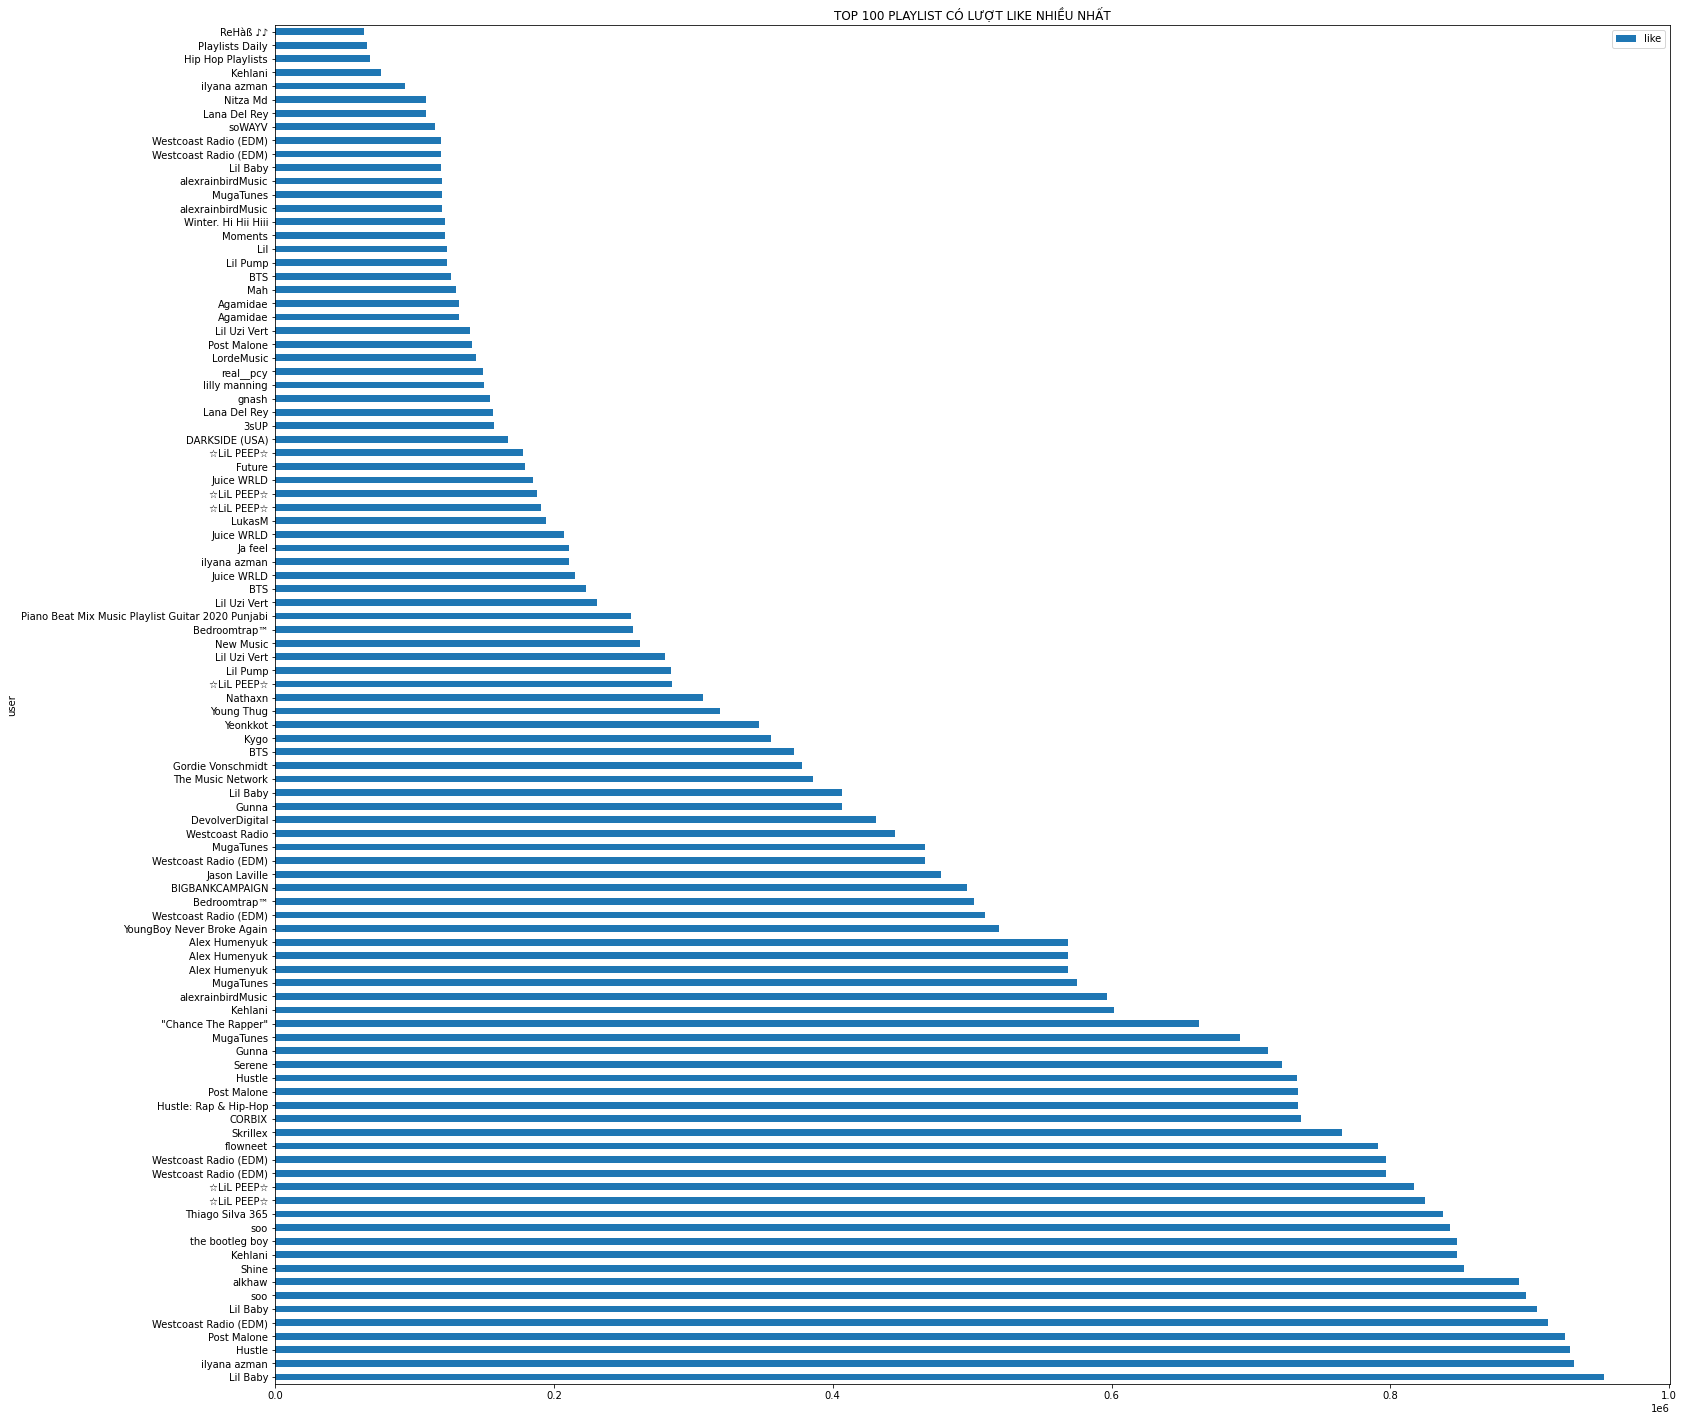

In [213]:
top100_playlist_like.plot.barh(use_index=True,x='user',y='like',figsize=(25,25))
plt.title('TOP 100 PLAYLIST CÓ LƯỢT LIKE NHIỀU NHẤT')

Tìm top 100 playlist có số lượt repost nhiều nhất.

In [141]:
playlist_sorted2=playlist.sort_values(by=['repost'],ascending=False,ignore_index=True)
top100_playlist_repost=playlist_sorted2[:100]

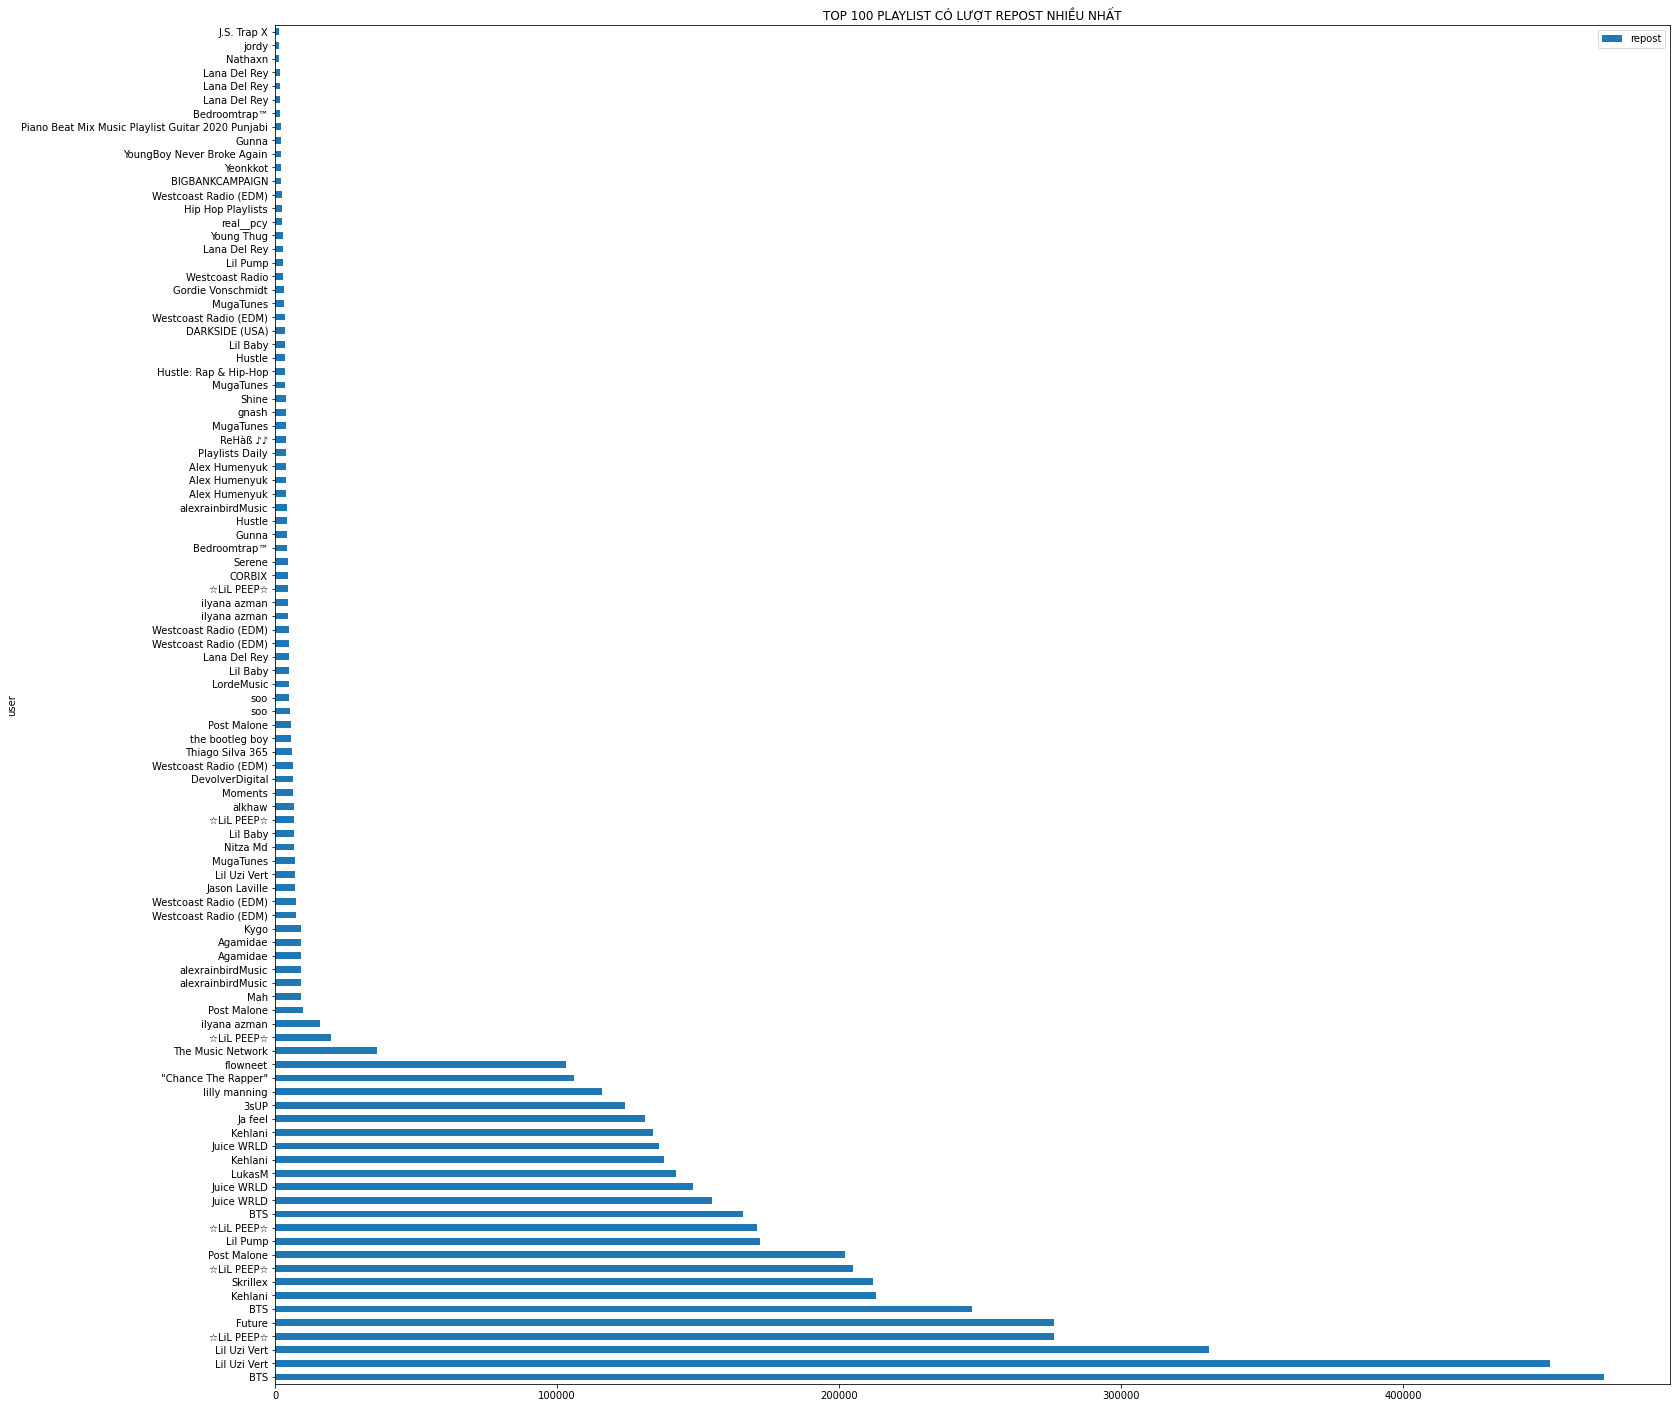

In [212]:
top100_playlist_repost.plot.barh(use_index=True,x='user',y='repost',figsize=(25,25))
plt.title('TOP 100 PLAYLIST CÓ LƯỢT REPOST NHIỀU NHẤT')
plt.show()

Top 100 người dùng có lượt follower cao nhất

In [144]:
top100_user_follower=user.sort_values(['follower_count'],ascending=False)[:100]

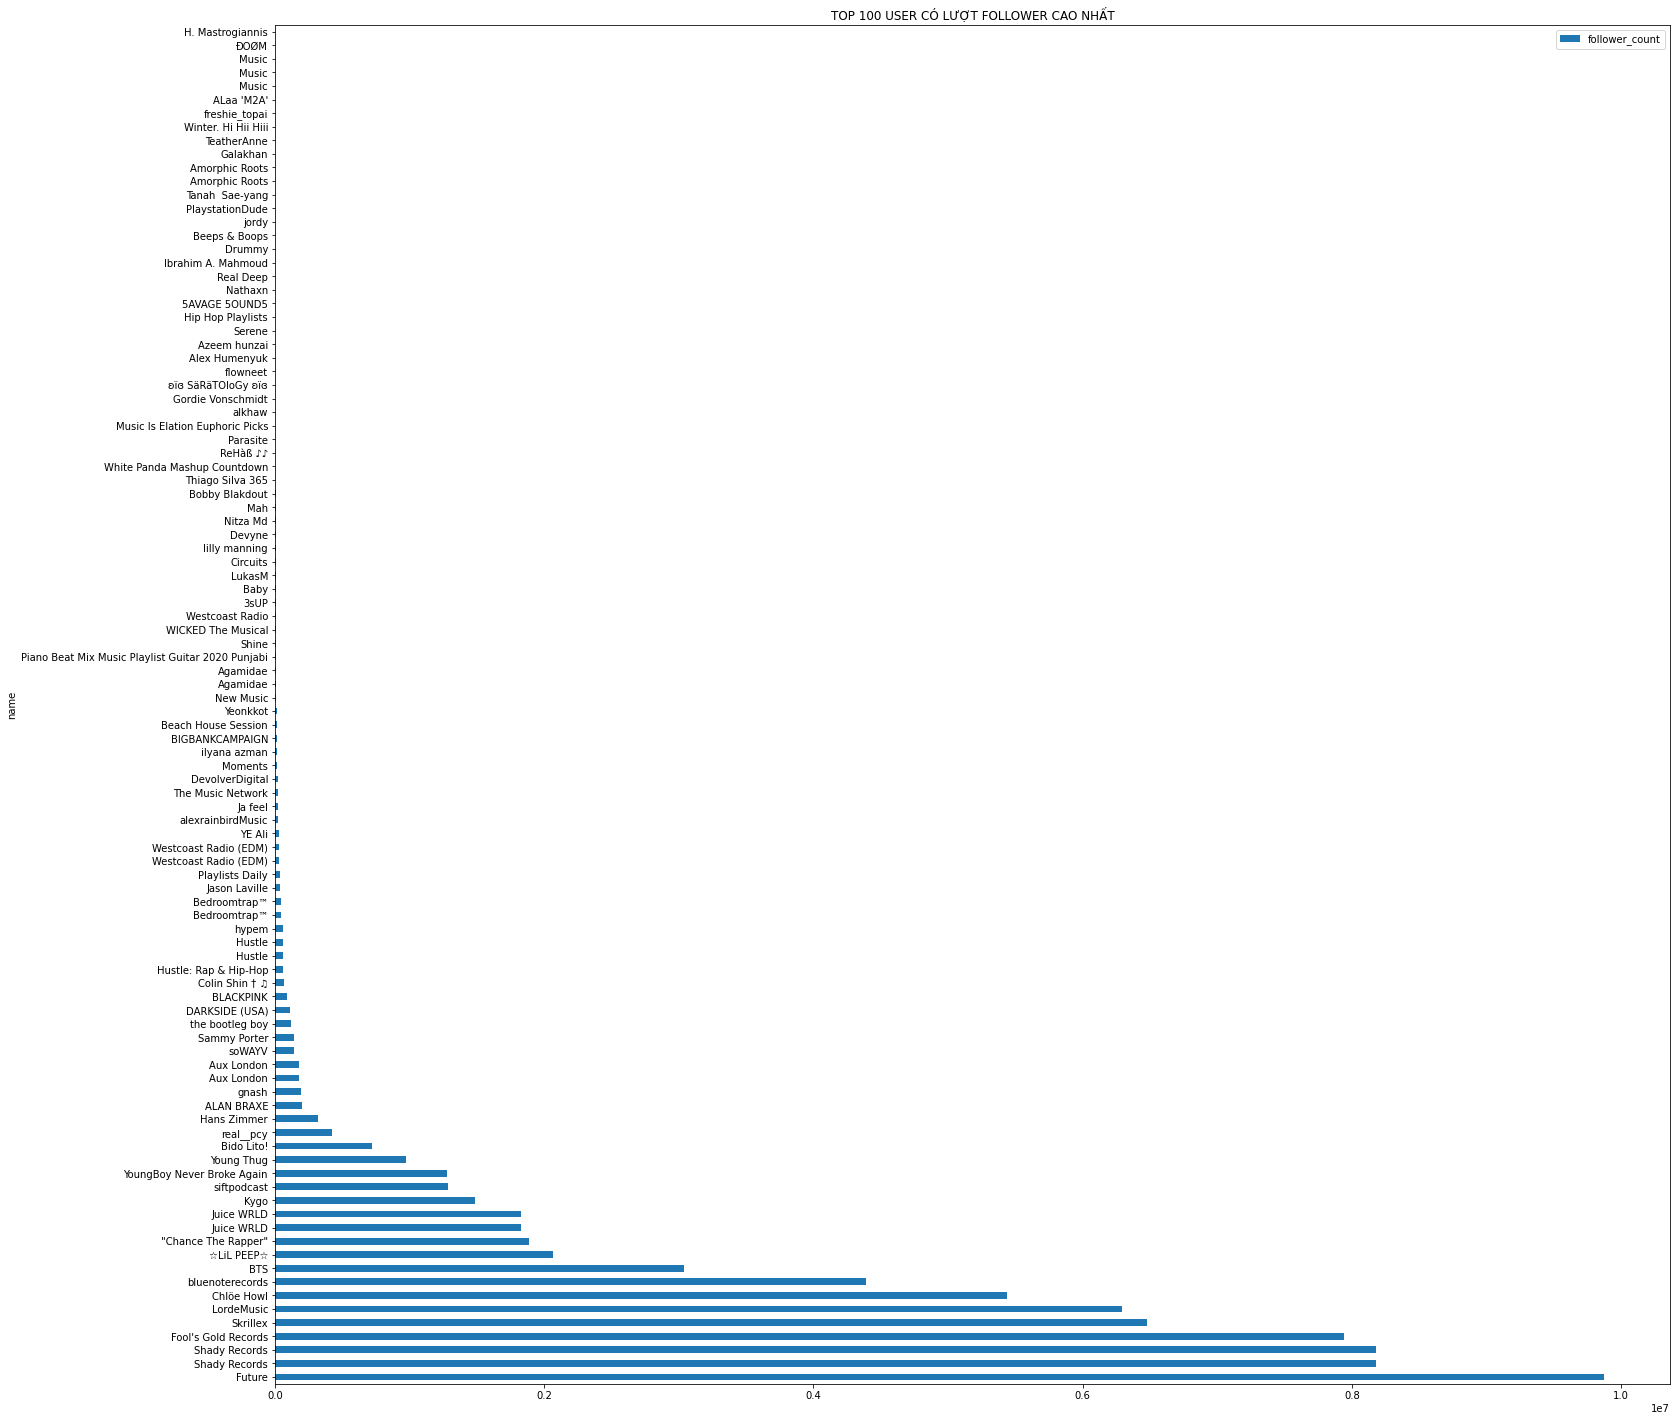

In [211]:
top100_user_follower.plot.barh(use_index=True,x='name',y='follower_count',figsize=(25,25))
plt.title('TOP 100 USER CÓ LƯỢT FOLLOWER CAO NHẤT')
plt.show()

In [146]:
user_plike=set(top100_playlist_like['user'])
user_prepost=set(top100_playlist_repost['user'])
user_follower=set(top100_user_follower['name'])

In [147]:
len(user_plike.intersection(user_follower))

49

In [148]:
len(user_prepost.intersection(user_follower))

47

In [149]:
len(user_prepost.intersection(user_plike))

56

In [150]:
top_user=user_plike.intersection(user_prepost)

In [151]:
top100_user=top_user.intersection(user_follower)
print("Number of user that have playlist in top100 repost and top100 like: ",len(top100_user))
print("====================================")
print(top100_user)

Number of user that have playlist in top100 repost and top100 like:  46
{'the bootleg boy', 'Hustle', 'Hip Hop Playlists', 'Mah', 'The Music Network', 'ilyana azman', 'real__pcy', 'Moments', 'Future', '☆LiL PEEP☆', 'Young Thug', 'Serene', 'Yeonkkot', 'BIGBANKCAMPAIGN', 'LordeMusic', 'DARKSIDE (USA)', 'LukasM', 'Nathaxn', 'Bedroomtrap™', 'DevolverDigital', 'Playlists Daily', 'Ja feel', '3sUP', 'Gordie Vonschmidt', 'Juice WRLD', 'Piano Beat Mix Music Playlist Guitar 2020 Punjabi', 'alkhaw', 'Alex Humenyuk', 'ReHàß ♪♪', 'Westcoast Radio (EDM)', 'Agamidae', 'Kygo', '"Chance The Rapper"', 'Nitza Md', 'gnash', 'Shine', 'YoungBoy Never Broke Again', 'Hustle: Rap & Hip-Hop', 'alexrainbirdMusic', 'Thiago Silva 365', 'BTS', 'lilly manning', 'Skrillex', 'Jason Laville', 'Westcoast Radio', 'flowneet'}


***Nhận xét:***  
_Trong top 100 playlist có lượt thích cao nhất, có khoảng 56 playlist có trùng số lượt repost nhiều nhất, và trong 56 playlist có lượt like và repost đó, có 46 user nằm trong top 100 người có lượng follower cao nhất.  
_Cũng cùng với top 100 repost, có 47 lượt trùng với top 100 người dùng với follower cao nhất.  
_Lượt trùng này là 49 đối với top 100 playlist có lượt like và top 100 người có lượng follower cao.  
_Như vậy, ta có thể thấy, chưa đến 50% mỗi trường hợp playlist có số lượt like, repost hoặc cả 2 nằm trong top100 cao nhất sẽ có người đăng tải (user) là người nằm trong top 100 user có lượt follower cao nhất. Tuy nhiên đây cũng không phải là một tỷ lệ quá thấp, ta vẫn nhận ra được giữa những người có follower cao thì những playlist họ đăng có được số lượt thích và lượt repost tồn tại một mối liên hệ (yếu).

#### ***-Thể loại nhạc nào được ưa chuộng trong vòng 2 năm mới nhất.***

Thống kê tỷ lệ các thể loại nhạc có được.

In [152]:
genre_group=track.groupby(['genre'])['genre'].count()

In [153]:
genre_pro=genre_group/max(genre_group)

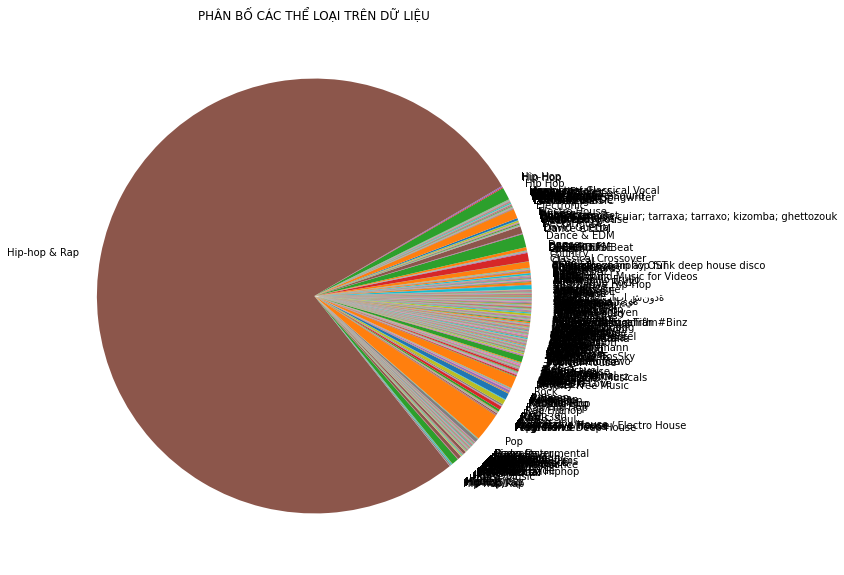

In [179]:
fig=plt.figure(figsize=(10,10))
plt.title('PHÂN BỐ CÁC THỂ LOẠI TRÊN DỮ LIỆU')
plt.pie(genre_pro,labels=genre_group.index)
plt.show()

Lĩnh vực Hip-hop và Rap chiếm tỷ trọng lớn (do sự điền dữ liệu thiếu đã dùng đến thể loại xuất hiện nhiều nhất), kế tiếp đó là Pop.

Thời gian 2 năm gần nhất.

In [155]:
track_coppy=track

In [161]:
top_2year=[]

In [160]:
top=track_coppy.sort_values(by=['last_modified'],ascending=False,ignore_index=True)

In [167]:
for i in range(len(top)):
    dt=top['last_modified'][i]
    dt=dt.split('-')[0]
    top.loc[i,'last_modified']=dt

Tỷ lệ số lượng bài hát có được trong từng năm.

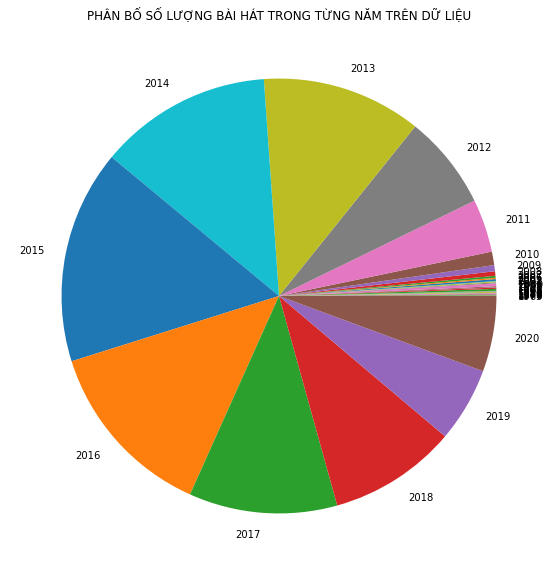

In [178]:
track_by_year=top.groupby(['last_modified'])['id_track'].count()

fig=plt.figure(figsize=(10,10))
plt.title('PHÂN BỐ SỐ LƯỢNG BÀI HÁT TRONG TỪNG NĂM TRÊN DỮ LIỆU')
plt.pie(track_by_year,labels=track_by_year.index)
plt.show()

Quan sát số lượng bài hát thay đổi theo từng năm.

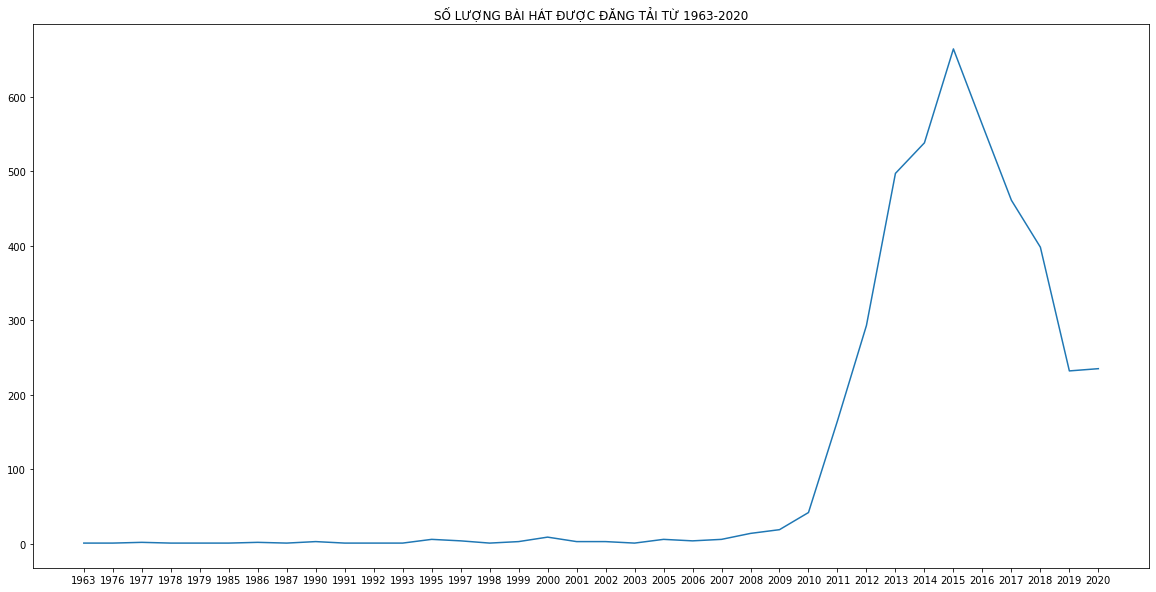

In [176]:
fig=plt.figure(figsize=(20,10))
plt.title('SỐ LƯỢNG BÀI HÁT ĐƯỢC ĐĂNG TẢI TỪ 1963-2020')
plt.plot(track_by_year)
plt.show()

Nhận thấy rằng, số lượng bài hát được đăng tải trong 10 năm trở lại đây tăng lên vượt bậc. Cũng có thể là do số lượng từ khóa tìm kiếm để thu thập dữ liệu được lấy chủ yếu từ top, new, hot và các nghệ sĩ mới.

In [177]:
#Tổng số bài hát (track) trong 2 năm 2019 và 2020
print(int(track_by_year['2020'])+int(track_by_year['2019']))

467


In [182]:
track_2year_near=top[:467]

Thống kê các thể loại nhạc trong năm 2019 và 2020

In [187]:
genre_2year=track_2year_near.groupby(['genre'])['id_track'].count()
top_genre_2year=genre_2year.to_frame()
top_genre_2year

,id_track
genre,
102BPM,1
3000 Bass,1
Alternative,1
Ambient,1
Background Music for Videos,1
Bass,2
Classical,1
Classical Crossover,1
Country,1


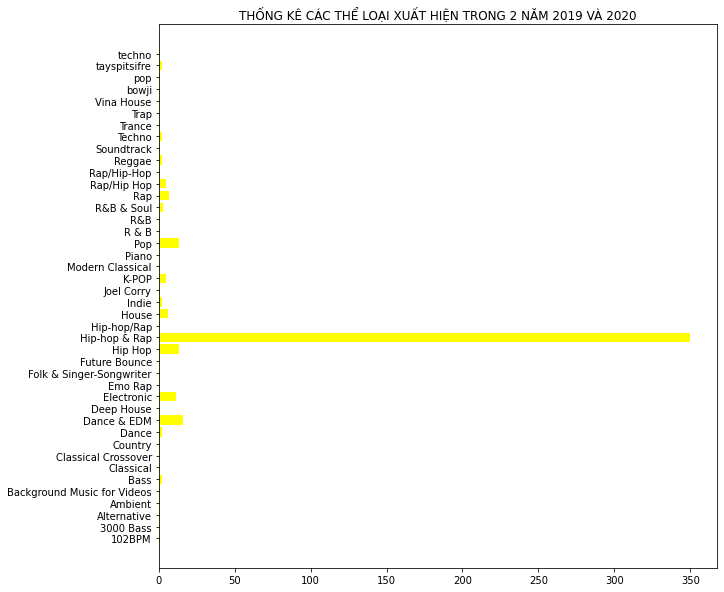

In [205]:
x=top_genre_2year.index
y=top_genre_2year['id_track']

fig=plt.figure(figsize=(10,10))
plt.title('THỐNG KÊ CÁC THỂ LOẠI XUẤT HIỆN TRONG 2 NĂM 2019 VÀ 2020')
plt.barh(x,y,color='yellow')
plt.show()

***Nhận xét:*** Theo thống kê trên dữ liệu có được. Hiphop-Rap và thể loại nhặc được ưa chuộng nhất trong 2 năm gần nhất (2019-2020). Kế đó sẽ là các thể loại về Pop, Hiphop và Dance&EDM.

#### ***-Những User nào có nhiều bài hát đạt top 50 có nhiều lượt like và play back nhất***

Top50 các bài hát có nhiều lượt play back (phát lại) nhất.

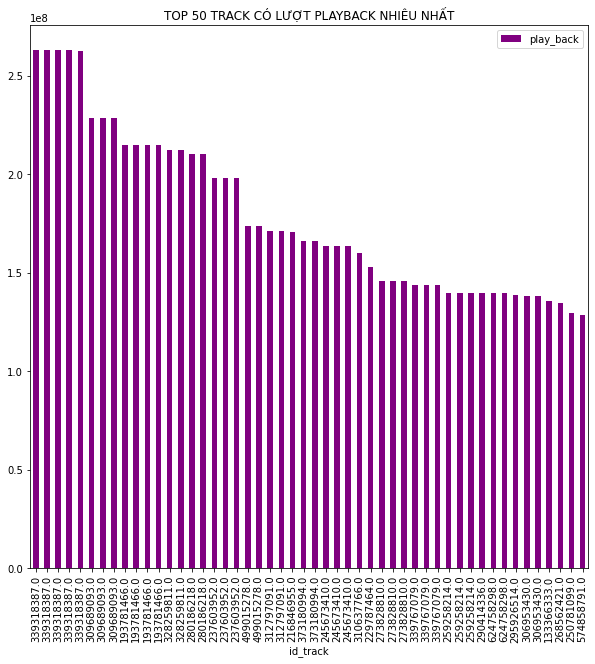

In [206]:
top50_track_playback=track_coppy.sort_values(by=['play_back'],ascending=False)[:50]
top50_track_playback.plot.bar(use_index=True,x='id_track',y='play_back',figsize=(10,10),color='purple')
plt.title('TOP 50 TRACK CÓ LƯỢT PLAYBACK NHIÊU NHẤT')
plt.show()

Top50 bài hát có số lượt like nhiều nhất.

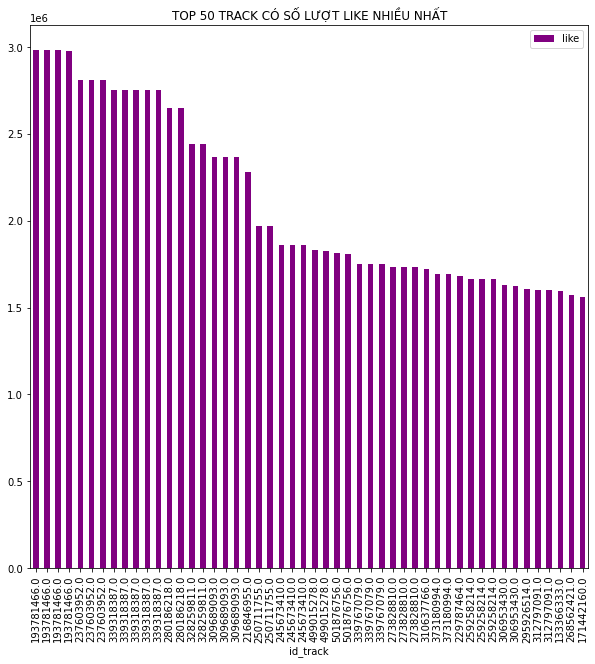

In [207]:
top50_track_like=track_coppy.sort_values(by=['like'],ascending=False)[:50]
top50_track_like.plot.bar(use_index=True,x='id_track',y='like',figsize=(10,10),color='purple')
plt.title('TOP 50 TRACK CÓ SỐ LƯỢT LIKE NHIỀU NHẤT')
plt.show()

[]

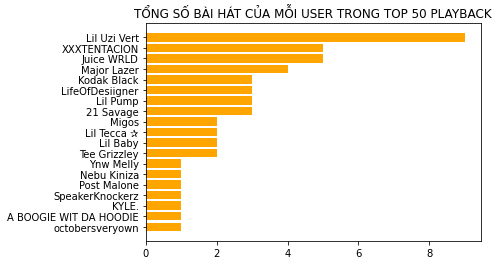

In [208]:
count_topUser_top50_track_playback=top50_track_playback.groupby(['user'])['id_track'].count()
topUser_top50_track_playback=count_topUser_top50_track_playback.to_frame().sort_values(by='id_track')

x=topUser_top50_track_playback.index
y=topUser_top50_track_playback['id_track']

plt.title('TỔNG SỐ BÀI HÁT CỦA MỖI USER TRONG TOP 50 PLAYBACK')
plt.barh(x,y,color='orange')
plt.plot()

Ta nhận thấy, trong top 50 track có lượt play back cao nhất trên dữ liệu thu thập được, ta có 18 người dùng, nghệ sĩ sở hữu bài hát đó, danh sách người cùng với số lượng track sở hữu trong top 50 playback bao gồm:

In [209]:
topUser_top50_track_playback

,id_track
user,
octobersveryown,1
A BOOGIE WIT DA HOODIE,1
KYLE.,1
SpeakerKnockerz,1
Post Malone,1
Nebu Kiniza,1
Ynw Melly,1
Tee Grizzley,2
Lil Baby,2


[]

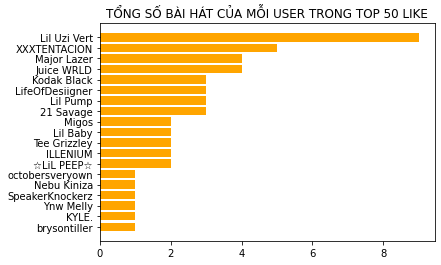

In [210]:
count_topUser_top50_track_like=top50_track_like.groupby(['user'])['id_track'].count()
topUser_top50_track_like=count_topUser_top50_track_like.to_frame().sort_values(by='id_track')

x=topUser_top50_track_like.index
y=topUser_top50_track_like['id_track']

plt.title('TỔNG SỐ BÀI HÁT CỦA MỖI USER TRONG TOP 50 LIKE')
plt.barh(x,y,color='orange')
plt.plot()

Trong top 50 track có lượt like cao nhất trên dữ liệu thu thập được, ta có 19 người dùng, nghệ sĩ sở hữu bài hát đó, danh sách người cùng với số lượng track sở hữu trong top 50 like bao gồm:

In [77]:
topUser_top50_track_like

,id_track
user,
brysontiller,1
KYLE.,1
Ynw Melly,1
SpeakerKnockerz,1
Nebu Kiniza,1
octobersveryown,1
☆LiL PEEP☆,2
ILLENIUM,2
Tee Grizzley,2


Bây giờ, ta sẽ xem xét các người dùng (nghệ sĩ) nào cùng nằm trong cả 2 top có số lượng bài hát đạt top 50 like và playback cao nhất.

In [81]:
topUser=set(count_topUser_top50_track_like.index).intersection(set(count_topUser_top50_track_playback.index))
topUser

{'21 Savage',
 'Juice WRLD',
 'KYLE.',
 'Kodak Black',
 'LifeOfDesiigner',
 'Lil Baby',
 'Lil Pump',
 'Lil Uzi Vert',
 'Major Lazer',
 'Migos',
 'Nebu Kiniza',
 'SpeakerKnockerz',
 'Tee Grizzley',
 'XXXTENTACION',
 'Ynw Melly',
 'octobersveryown'}

***Nhận xét:***  
- Với top50 track có lượt playback nhiều nhất, có 18 user là chủ nhân đăng tải những playlist này, trong đó Lil Uzi Vert là người có số lượng track trong top nhiều nhất.
- Cùng với top50 lượt playback là top50 lượt like, có 19 user là chủ nhân đăng tải và trong đó, Lil Uzi Vert vẫn là nguời có số lượng track nhiều nhất.
- Cuối cùng, có 16 user có số trạk đạt lượng like và lượng playback nằm trong top50. Và Lil Uzi Vert và XXXTENCAION là 2 người đứng top đầu khi có nhiều track đạt top nhất.